# Integration with Artificial Thymic Organoid data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys,os
import scvi
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scvelo as scv

In [4]:
## import utils
cwd = '.'
sys.path.append(cwd)

import map_query_utils

In [5]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/invivoVSinvitro/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir


In [6]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [7]:
%load_ext rpy2.ipython


In [8]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [9]:
def _plot_sorted_violin(merged_adata_bcells, groupby, y_value):
    n_cells_anno = merged_adata_bcells.obs[[groupby,y_value]].value_counts(groupby)
    keep_anno = n_cells_anno.index[n_cells_anno > 30]

    mean_sim = merged_adata_bcells.obs[[groupby,y_value]].groupby(groupby).mean()
    anno_order = mean_sim.loc[keep_anno].sort_values(y_value, ascending=False).index.tolist()

    merged_adata_bcells.var_names_make_unique()
    sc.pl.violin(merged_adata_bcells[merged_adata_bcells.obs[groupby].isin(keep_anno)], 
                                     y_value, groupby=groupby, rotation=90, 
                                     order=anno_order)

## Prepare data for mapping 

### Load dataset

Provided by Chenqu, and re-saved by me to have EnsemblIDs as `var_names`

In [247]:
ato_data_dir = "/lustre/scratch117/cellgen/team205/cs42/jovyan_25082021/thymic_organoid_new/matrix/"
metadata_file = '/lustre/scratch117/cellgen/team205/cs42/jovyan_25082021/thymic_organoid_new/manifest/metadata_v4.csv'
keep_samples = ['6180STDY9448808', '6180STDY9448811', '6180STDY9448813']

In [248]:
ato_metadata = pd.read_csv(metadata_file)

In [249]:
def simple_filtering_pp(adata, min_n_count = 2000, min_n_gene = 500, max_n_gene = 7000):
    import scrublet as scr
    # caculate n_counts / n_genes per cell
    adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
    adata.obs['n_genes'] = np.sum(adata.X>0,axis=1)

    print("Filtering cells...")
    clist = []
    clist.append(np.array(adata.obs['n_counts'] > min_n_count))
    clist.append(np.array(adata.obs['n_genes'] > min_n_gene))
    clist.append(np.array(adata.obs['n_genes'] < max_n_gene))

    c = np.column_stack(clist).all(axis=1)
    adata = adata[c].copy()

    adata = adata[:,np.argsort(adata.var.gene_ids)]

    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['mito'] = (np.sum(adata.X[:, mito_genes],axis=1).A1) / (np.sum(adata.X,axis=1).A1)
    
    ## Find mouse cells
    adata.var['human'] = adata.var_names.str.startswith('GRCh38')
    adata.var['mouse'] = adata.var_names.str.startswith('mm10_')
     
    sc.pp.calculate_qc_metrics(adata, qc_vars=["human"], inplace=True)
    adata.obs['human_cells'] = adata.obs['pct_counts_human'] > 0.9
    
    print("Computing doublets...")
    scrub = scr.Scrublet(adata.X)
    if adata.shape[0] < 30:
        doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False, n_prin_comps=adata.shape[0] - 1)
    else:
        doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)
    adata.obs['doublet_scores'] = doublet_scores
    adata.obs['predicted_doublets'] = predicted_doublets
    return(adata)

In [250]:
adata_ls = []
for s in keep_samples:
    ato_adata = sc.read_10x_mtx(ato_data_dir + s + "/raw")
    ato_adata = simple_filtering_pp(ato_adata)
    ato_adata.obs["sequence_name"] = s
    adata_ls.append(ato_adata)

for adata in adata_ls:
    ## Find mouse cells
    adata.var['human'] = adata.var_names.str.startswith('GRCh38')
    adata.var['mouse'] = adata.var_names.str.startswith('mm10_')
     
    sc.pp.calculate_qc_metrics(adata, qc_vars=["human"], inplace=True)
    adata.obs['human_cells'] = adata.obs['pct_counts_human'] > 0.9

# ## Save barcodes for human cells
# bcdir = '/nfs/team205/ed6/data/Fetal_immune/barcodes4souporcell/'
# for a in adata_ls:
#     s = a.obs['sequence_name'].unique()[0]
#     outdir = bcdir + s + "/"
#     if not os.path.exists(outdir):
#         os.mkdir(outdir)
#     file = outdir + 'human_barcodes.csv'
#     with open(file, 'w') as f:
#         for bc in a.obs_names[a.obs["human_cells"]].tolist():
#             f.write("%s\n" % bc)

## Restrict to human cells
adata_ls = [a[a.obs['human_cells']].copy() for a in adata_ls]

## Add metadata
for a in adata_ls:
    merged_obs = pd.merge(a.obs, ato_metadata)
    merged_obs.index = a.obs_names
    a.obs = merged_obs.copy()

Trying to set attribute `.obs` of view, copying.


Filtering cells...
Computing doublets...


Trying to set attribute `.obs` of view, copying.


Filtering cells...
Computing doublets...
Filtering cells...


Trying to set attribute `.obs` of view, copying.


Computing doublets...


In [251]:
for a in adata_ls:
    a.obs_names = a.obs_names + "_" + a.obs["sequence_name"]

In [252]:
ato_adata = anndata.concat(adata_ls)

In [253]:
## Filter genes
ato_adata = ato_adata[:,ato_adata.var_names.str.startswith("GRCh")].copy()
ato_adata.var_names = [x[1] for x in ato_adata.var_names.str.split("GRCh38_")]

### QC and exploration

In [254]:
ato_adata_pp = ato_adata.copy()
sc.pp.normalize_per_cell(ato_adata_pp)
sc.pp.log1p(ato_adata_pp)
sc.pp.scale(ato_adata_pp)
sc.pp.pca(ato_adata_pp)
sc.pp.neighbors(ato_adata_pp)
sc.tl.umap(ato_adata_pp)
# adata.obsm["X_pca"] = ato_adata_pp.obsm["X_pca"].copy()
# adata.obsm["X_umap"] = ato_adata_pp.obsm["X_umap"].copy()

... storing 'sequence_name' as categorical
... storing 'Fiaj' as categorical
... storing 'Kolf' as categorical
... storing 'MS5hDLL4' as categorical
... storing 'iPSC source' as categorical
... storing 'iPSC passage' as categorical
... storing 'Date_of_sample' as categorical
... storing 'FACS_sort' as categorical
... storing '10x_kit' as categorical
... storing 'sanger_sample_ID' as categorical
... storing 'TCR' as categorical


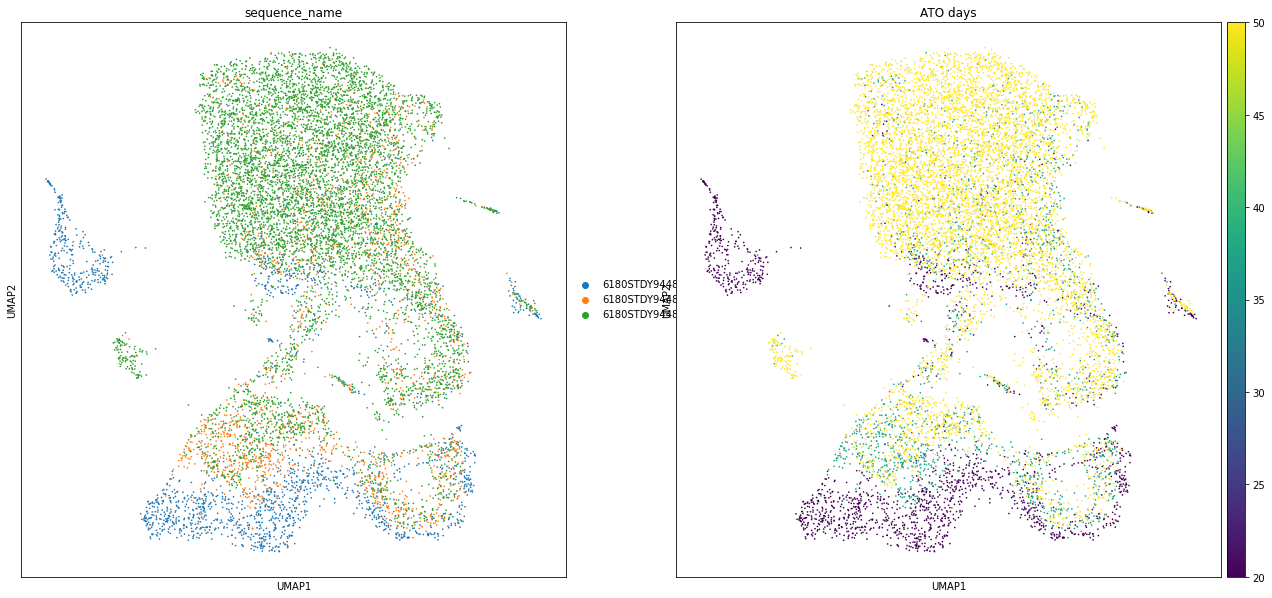

In [255]:
sc.pl.umap(ato_adata_pp, color=['sequence_name', "ATO days"])

In [286]:
# ## Load NK/T markers
# def plot_markers(adata, markers_df, ct):
#     ct_markers = markers_df.gene[markers_df.anno_lvl_2==ct]
#     sc.pl.umap(adata, color=ct_markers[ct_markers.isin(adata.var_names)])
    
# nkt_markers = pd.read_csv("../../metadata/marker_genes/NKT_marker_genes_09072021_clean.csv", index_col=0)

In [263]:
## Load annotated data by Chenqu
ato_adata_cs42 = sc.read_h5ad('/lustre/scratch117/cellgen/team205/cs42/jovyan_25082021/thymic_organoid_new/write/ATO.A05.v01.merged_annotated.h5ad')

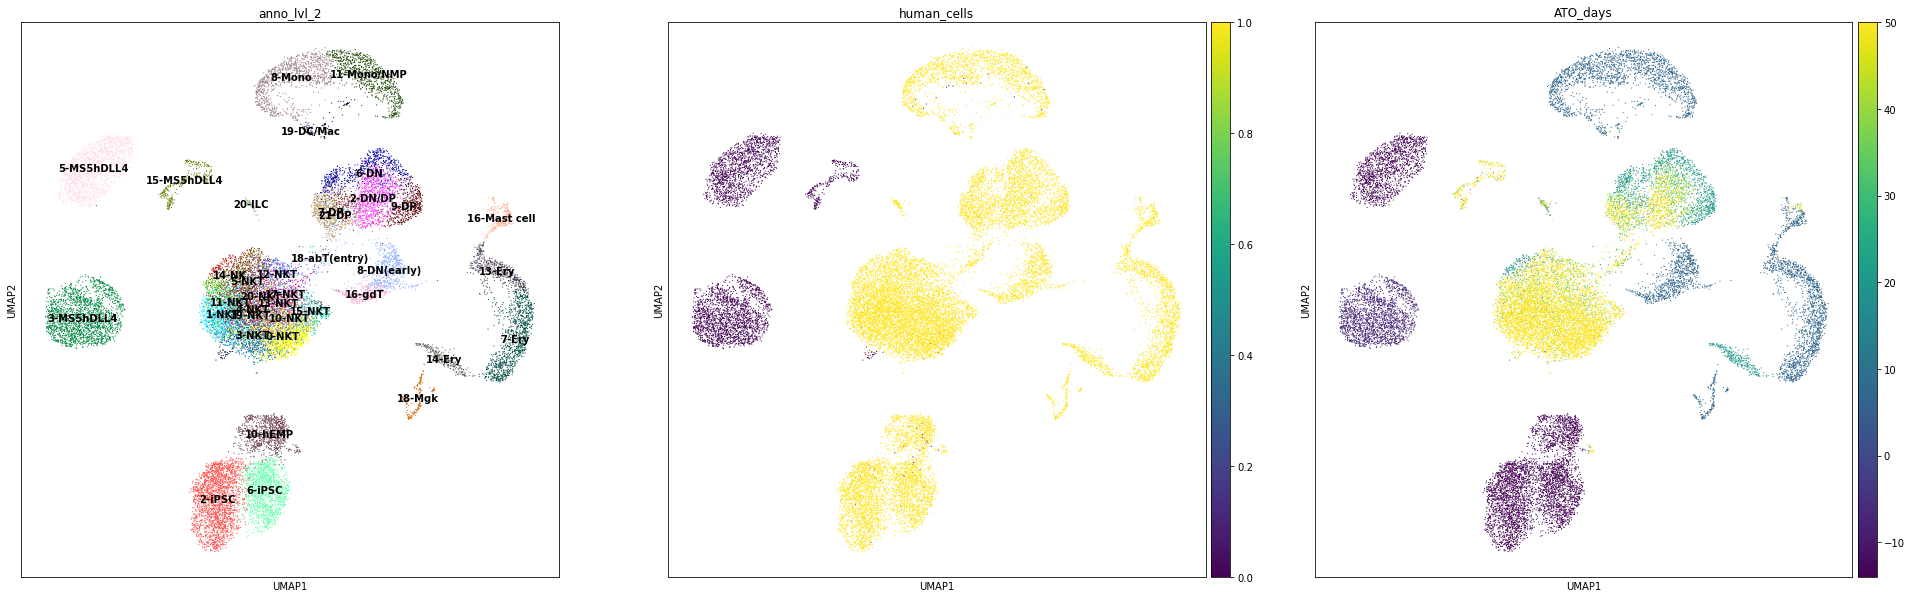

In [282]:
plt.rcParams["figure.figsize"] = [10,10]
ato_adata_cs42.obs["human_cells"] = ato_adata_cs42.obs["human_cells"].astype("int")
sc.pl.umap(ato_adata_cs42, color=["anno_lvl_2", "human_cells", 'ATO_days'], legend_loc='on data')


... storing 'anno_lvl_2_cs42' as categorical


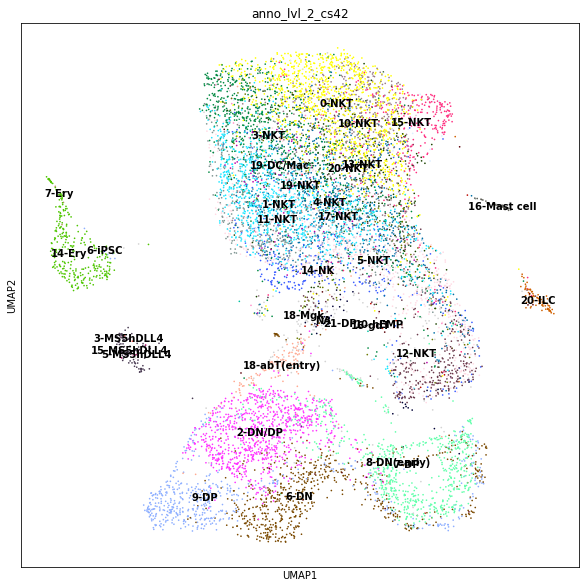

In [287]:
anno_df = ato_adata_cs42.obs.copy()
anno_df.index = ['_'.join([x[1] + "-1", x[0]]) for x in ato_adata_cs42.obs_names.str.split("-")]

ato_adata.obs['anno_lvl_2_cs42'] = [anno_df.loc[x]['anno_lvl_2'] if x in anno_df.index else np.nan for x in ato_adata.obs_names]

ato_adata_pp.obs['anno_lvl_2_cs42'] = ato_adata.obs['anno_lvl_2_cs42'].copy()

sc.pl.umap(ato_adata_pp, color='anno_lvl_2_cs42', legend_loc='on data')

### Save for query to reference mapping

In [ ]:
## Gene names 2 ENSEMBL ids
gene_ids = adata_ls[0].var[['gene_ids']]
gene_ids = gene_ids[[x.startswith('GRCh38') for x in gene_ids.gene_ids]]
gene_ids.gene_ids = [x[1] for x in gene_ids.gene_ids.str.split("GRCh38_")]
gene_ids.index = [x[1] for x in gene_ids.index.str.split("GRCh38_")]

ato_adata.var['gene_ids'] = gene_ids.loc[ato_adata.var_names]['gene_ids']
ato_adata.var['gene_names'] = ato_adata.var_names.copy()
ato_adata.var_names = ato_adata.var['gene_ids'].copy()
ato_adata.var.index.name = None

In [315]:
## Check counts 
ato_adata.X.data

array([ 1.,  1.,  1., ...,  7.,  3., 50.], dtype=float32)

In [323]:
ato_adata.write_h5ad('/nfs/team205/ed6/data/Fetal_immune/ATO_query.h5ad')
ato_adata.write_h5ad('/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/ATO_query.h5ad')

## Train on scVI models

On GPU node, running the call:

We merge datasets and rerun embeddings running

### Load output

In [10]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'

In [11]:
merged_adata_file = 'panimmune_MYELOID_query.mapped2MYELOID.withReference.h5ad'
split = "MYELOID"
ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'
timestamp = '20210429'

In [20]:
merged_adata = sc.read_h5ad(ref_data_dir + merged_adata_file)

In [21]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
exclude_obs = reference_obs[reference_obs.str.strip("-reference").isin(mat_barcodes)]

merged_adata = merged_adata[~merged_adata.obs_names.isin(exclude_obs)].copy()

In [198]:
## Add metadata and annotations for the reference
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
    
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]

merged_adata.obs["annotation_reference"] = np.nan
merged_adata.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-reference")]["anno_lvl_2_final_clean"].values

merged_adata.obs["organ"] = np.nan
merged_adata.obs.loc[reference_obs, "organ"] = anno_obs.loc[reference_obs.str.strip("-reference")]["organ"].values
merged_adata.obs["age"] = np.nan
merged_adata.obs.loc[reference_obs, "age"] = anno_obs.loc[reference_obs.str.strip("-reference")]["age"].values

KeyError: "None of [Index(['Pan_T7935490_AACCATGTCTCGTTTA-query',\n       'Pan_T7935490_CGTAGGCCAATGGACG-query',\n       'Pan_T7935490_CGTCAGGCAGGGATTG-query',\n       'Pan_T7935490_CTACACCAGCGCTCCA-query',\n       'Pan_T7935490_CTCGAAAAGCGATATA-query',\n       'Pan_T7935490_CTCTACGCAGTAAGAT-query',\n       'Pan_T7935490_CTGTGCTAGGTGACCA-query',\n       'Pan_T7935490_CTGTTTATCACATAGC-query',\n       'Pan_T7935490_GACCTGGTCATGCTCC-query',\n       'Pan_T7935490_GATCGTATCCATGAAC-query',\n       ...\n       'Pan_T8986831_TGCCCTACAGTAAGCG-query',\n       'Pan_T8986831_TGGCGCACAATACGCT-query',\n       'Pan_T8986831_TGGCTGGCATGCAATC-query',\n       'Pan_T8986831_TGTCCCAGTAGGCATG-query',\n       'Pan_T8986831_TTAGTTCCAATACGCT-query',\n       'Pan_T8986831_TTCTCCTAGCGTGAGT-query',\n       'Pan_T8986831_TTCTCCTTCAACGAAA-query',\n       'Pan_T8986831_TTCTTAGAGTGTGGCA-query',\n       'Pan_T8986831_TTGCCGTTCGGCCGAT-query',\n       'Pan_T8986831_TTGGCAAAGAGTACCG-query'],\n      dtype='object', length=13062)] are in the [index]"

In [27]:
## Add metadata and annotations for the query
query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
merged_adata.obs["annotation_query"] = merged_adata.obs["anno_mye"]

In [ ]:
## Reverse UMAP coords (to match myeloid embedding)
merged_adata.obsm["X_umap_rev"] = merged_adata.obsm["X_umap"].copy()
merged_adata.obsm["X_umap"][:,1] = - merged_adata.obsm["X_umap"][:,1]

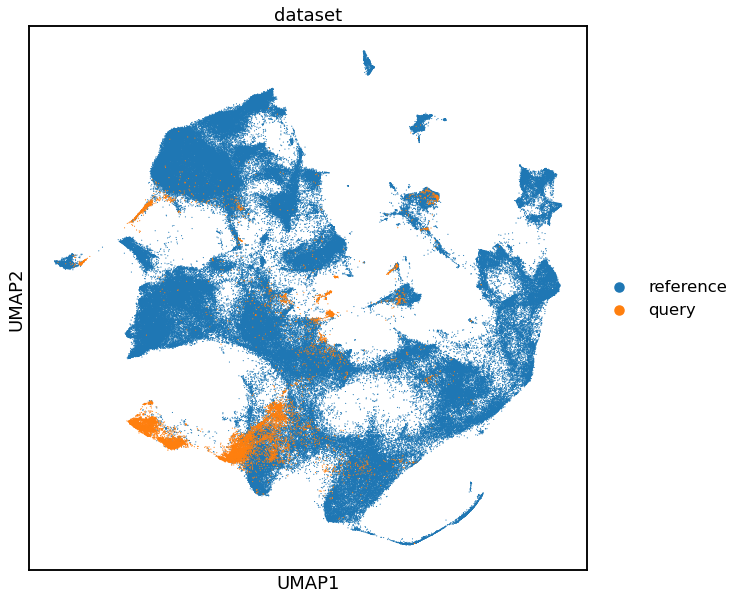

In [19]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_adata, color=["dataset"], size=5)

### Plot query and reference annotations

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/fetalVSadult_myeloid/scvelo_anno_query.png


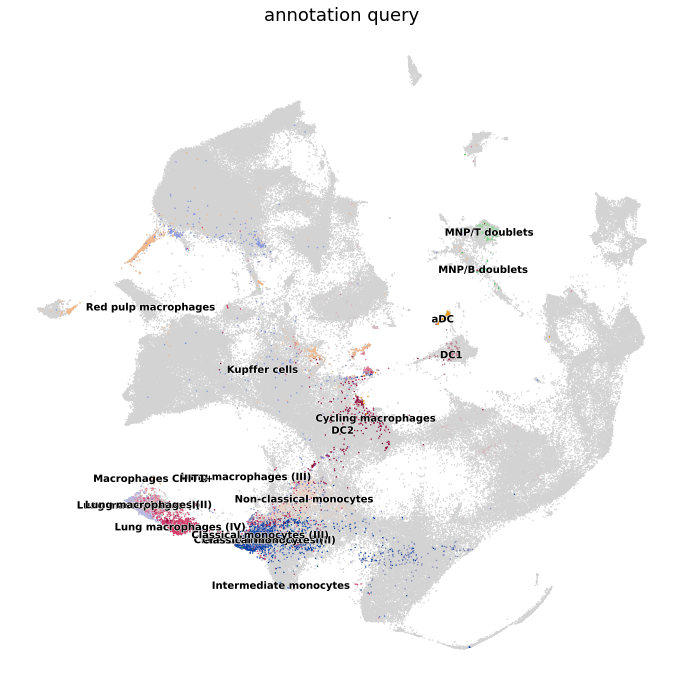

In [29]:
plt.rcParams['figure.figsize'] = [12,12]
anno_labels = merged_adata.obs["annotation_query"][merged_adata.obs["annotation_query"]!="nan"].unique().tolist()
scv.pl.umap(merged_adata, color=["annotation_query"], size=8, legend_loc="on data", groups=anno_labels, title="annotation query", legend_fontsize=10, 
            save="anno_query.png")

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/fetalVSadult_myeloid/scvelo_anno_reference.png


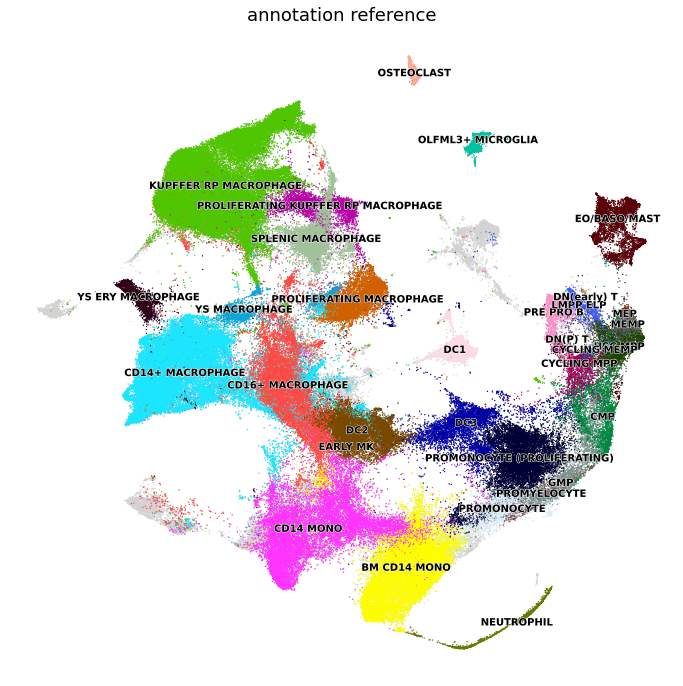

In [30]:
anno_labels = merged_adata.obs["annotation_reference"][merged_adata.obs["annotation_reference"]!="nan"].unique().tolist()
anno_labels = [x for x in anno_labels if type(x)==str]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["OTHER"]]

scv.pl.umap(merged_adata, color=["annotation_reference"], size=7, legend_loc="on data", groups=anno_labels, 
            legend_fontsize=10,
            title="annotation reference",
           save="anno_reference.png")

### Transfer labels

In [33]:
merged_adata.obs["annotation_reference"] = merged_adata.obs["annotation_reference"].astype("str").replace("nan", np.nan)
map_query_utils.predict_label(merged_adata, anno_col="annotation_reference")

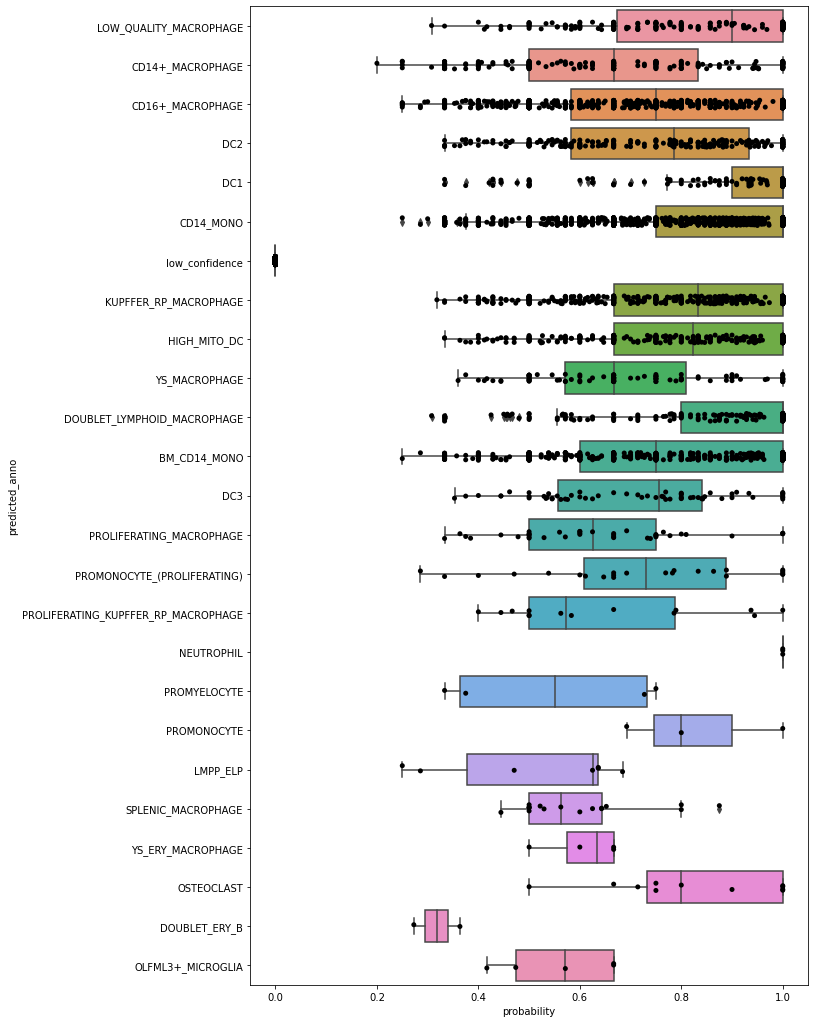

In [34]:
plt.rcParams["figure.figsize"] = [10,18]
map_query_utils.plot_predicted_anno_probability(merged_adata)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


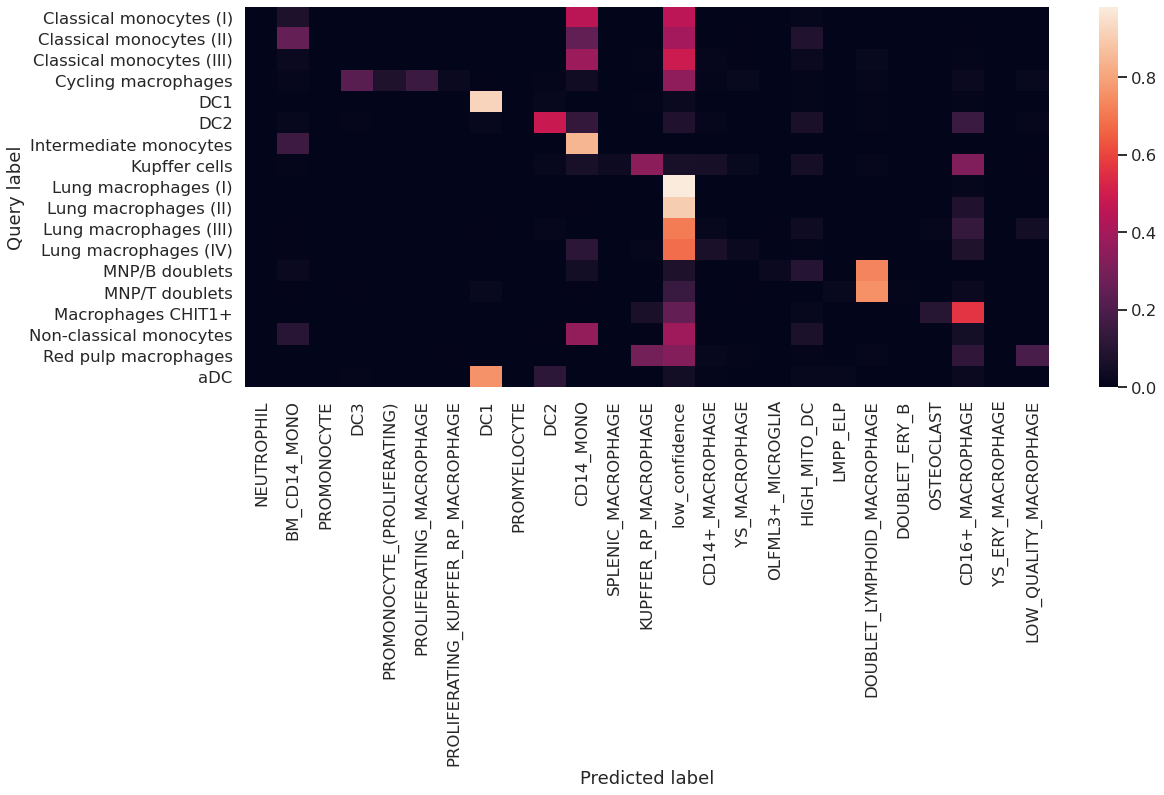

In [46]:
sns.set_context("talk")
query_anno_col="annotation_query"

query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
empty_query = query_obs[merged_adata[query_obs].obs[query_anno_col]=="nan"]
merged_adata_clean = merged_adata[~merged_adata.obs_names.isin(empty_query)]

plt.rcParams["figure.figsize"] = [18,7]
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)
plt.savefig(figdir + "confusion_label_transfer.pdf", bbox_inches="tight")

### Quantify matching between datasets

In [75]:
import time
start = time.time()
mnn_query, mnn_ref = map_query_utils._find_MNNs(merged_adata)
end = time.time()
print(end - start)

24.69906520843506


In [76]:
map_query_utils._MNN_to_KNN_similarity_ratio(merged_adata, mnn_ref, mnn_query)

... storing 'organ' as categorical


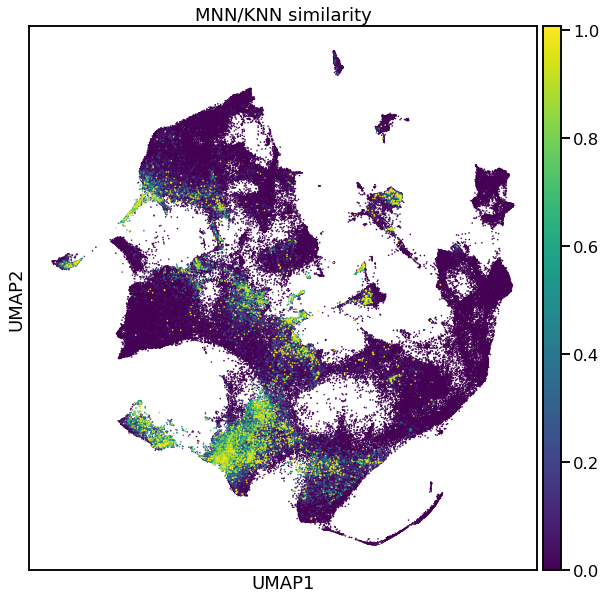

In [59]:
plt.rcParams["figure.figsize"] = [10,10]
sns.set_context("talk")
sc.pl.umap(merged_adata, color="mnn_sim_ratio", size=10, title="MNN/KNN similarity")

In [103]:
mpl.rcParams.update(mpl.rcParamsDefault)

[5.0, 15.0]

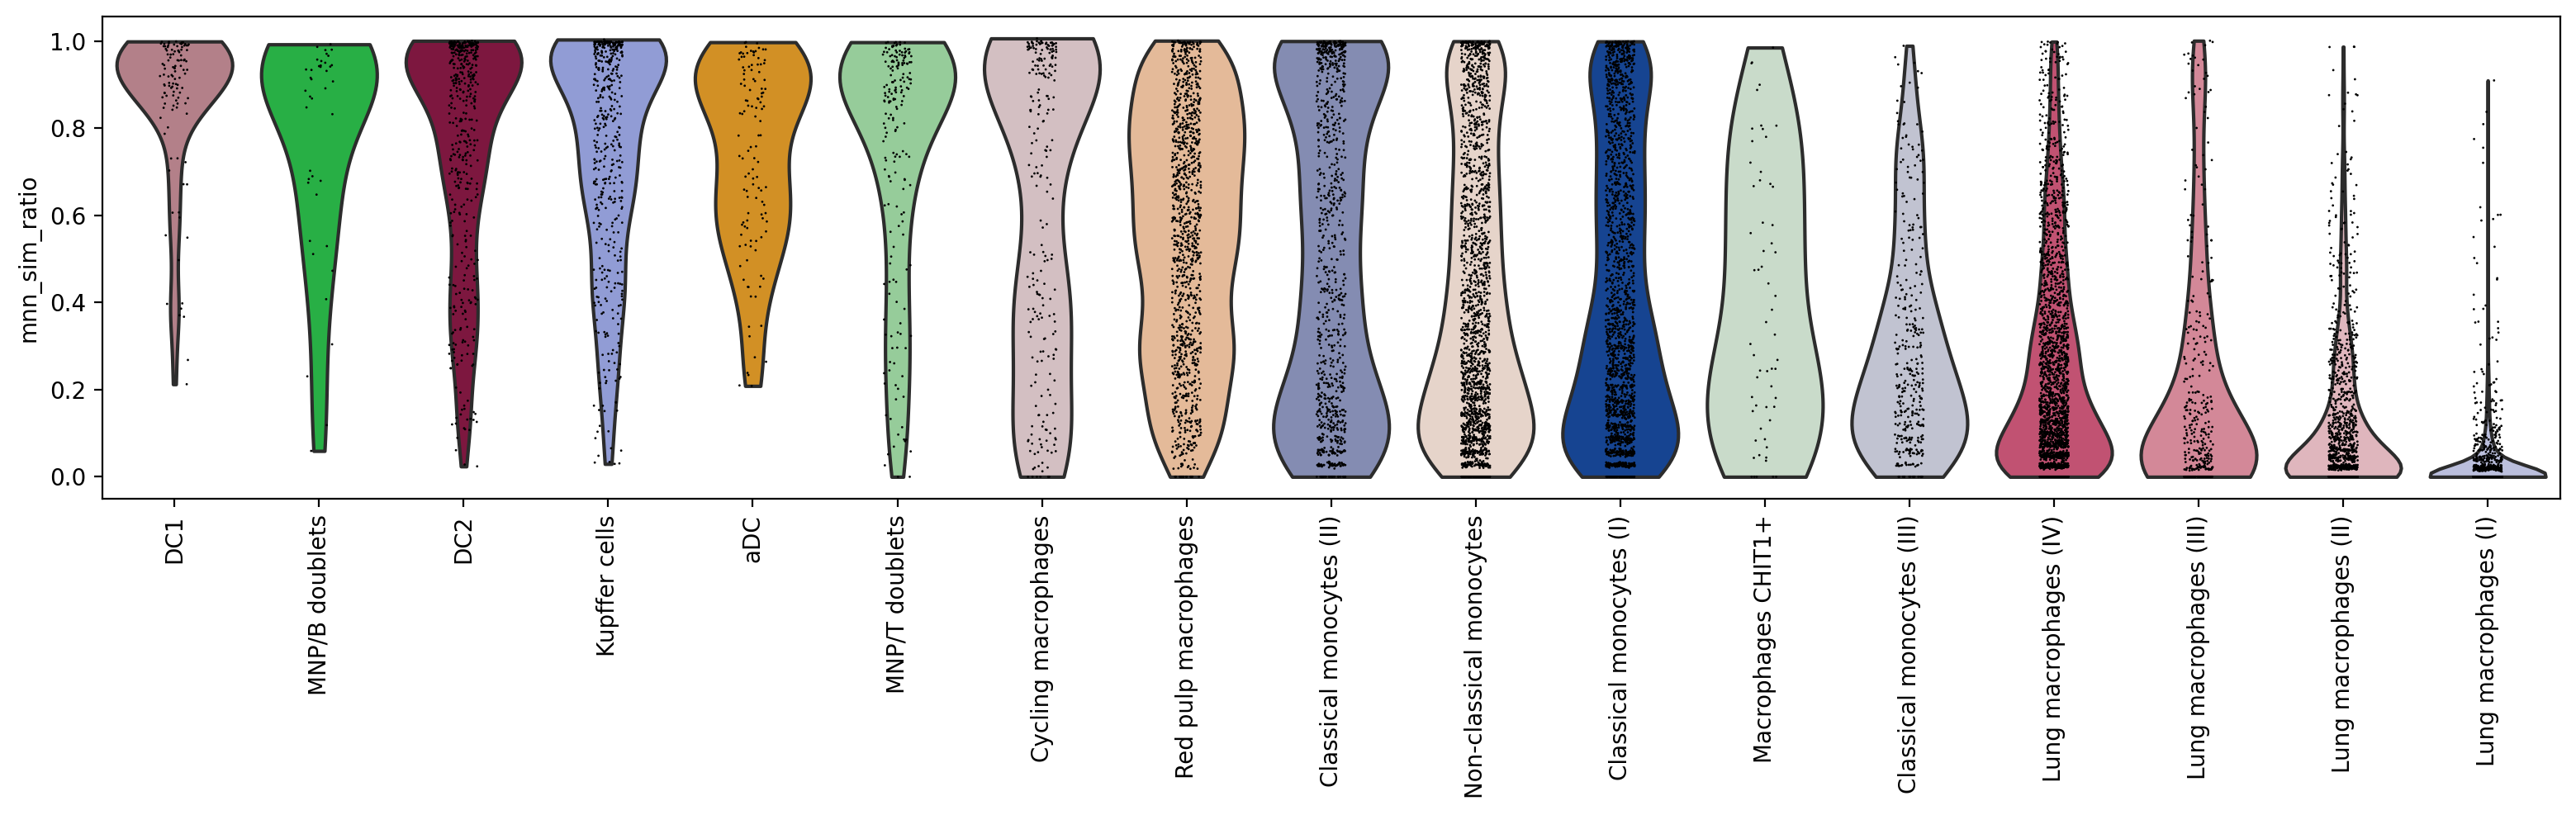

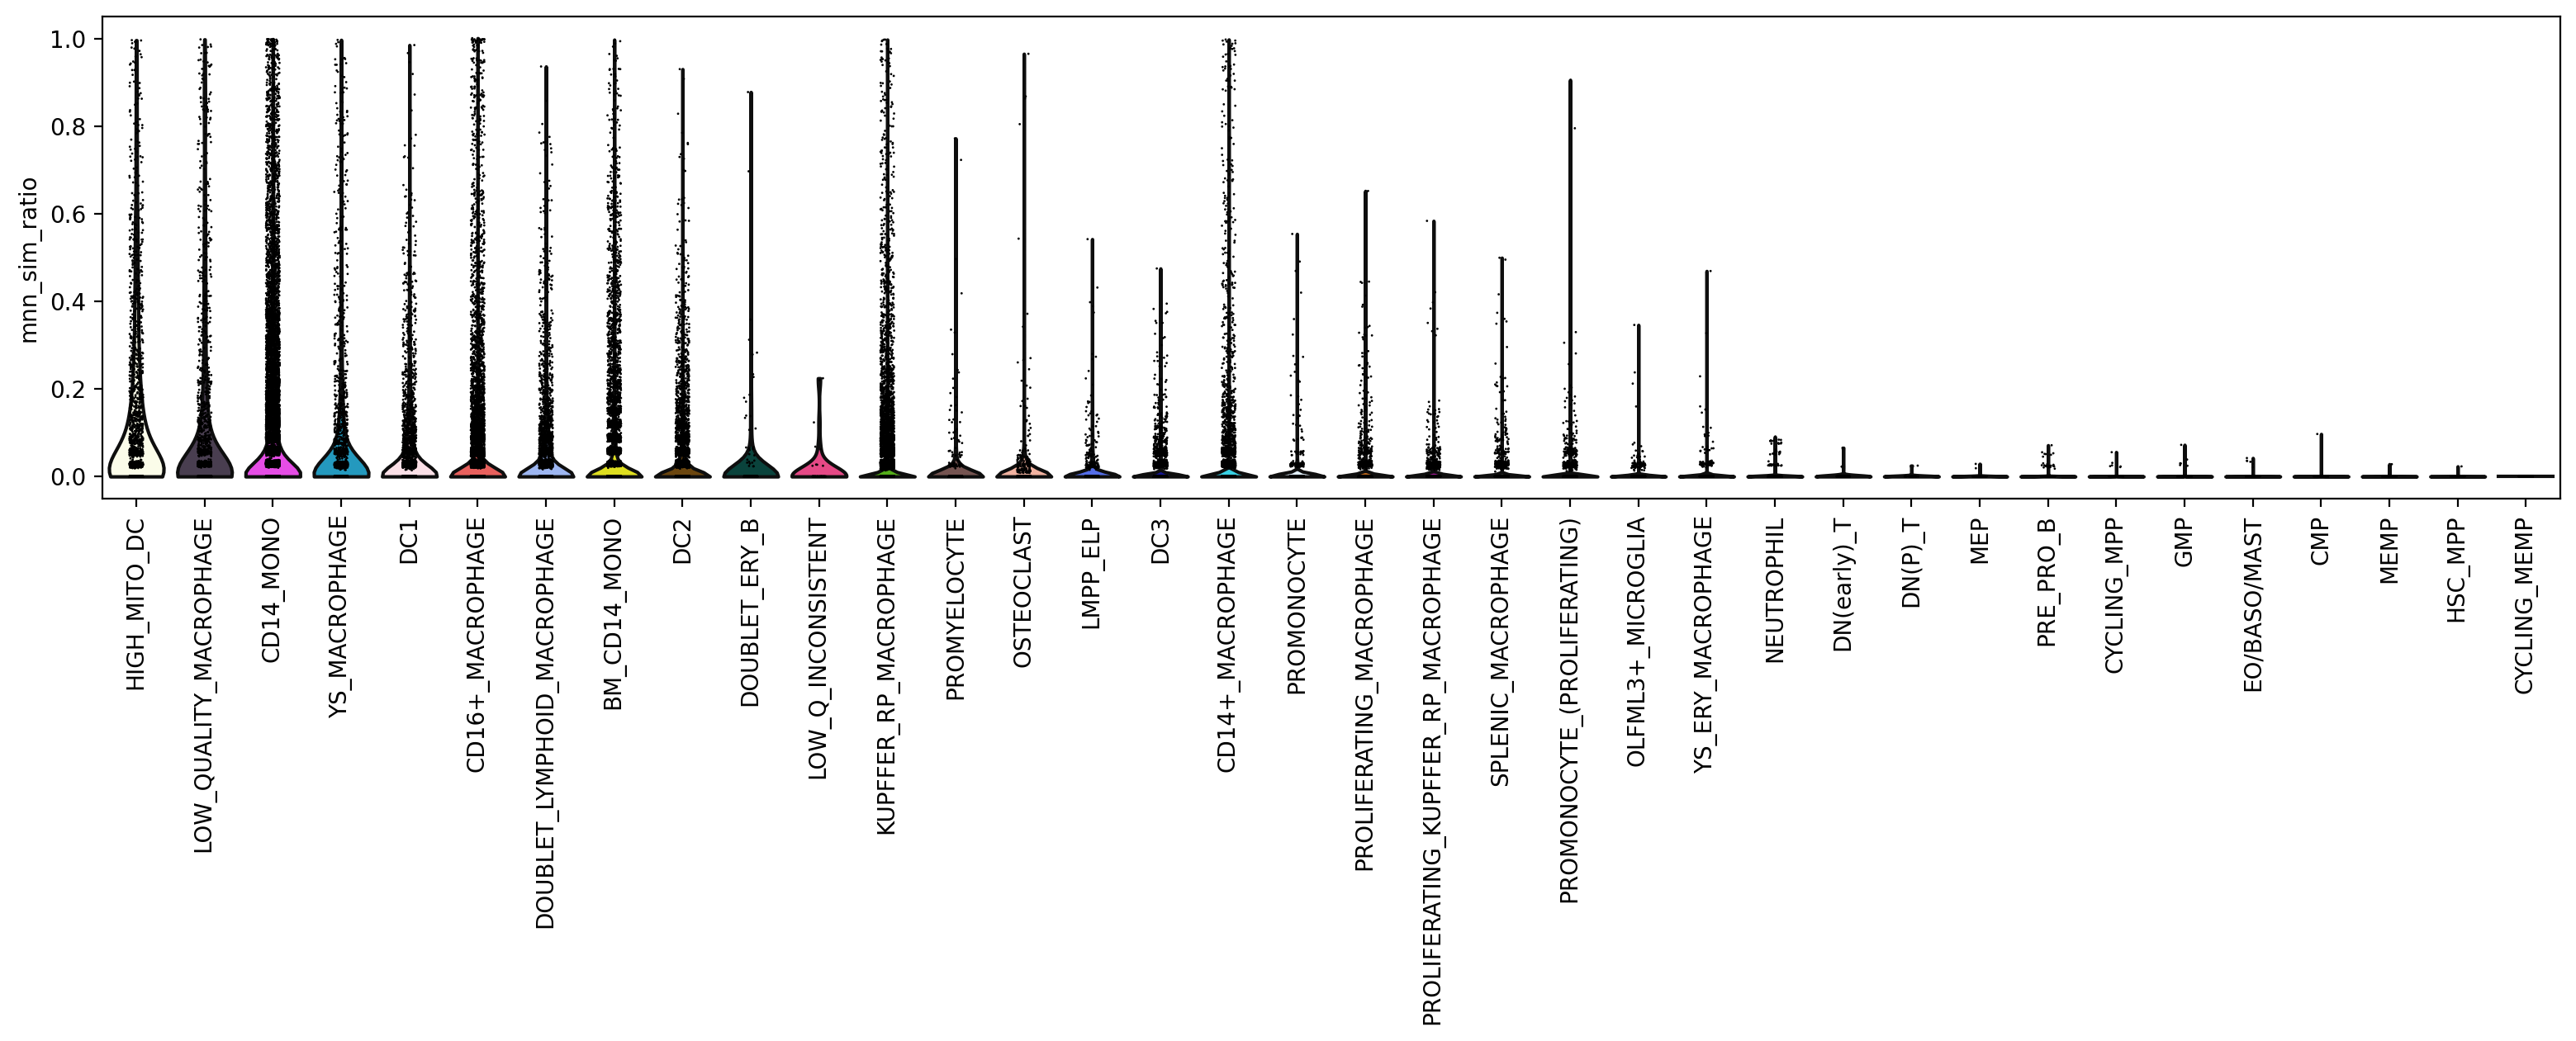

In [107]:
mpl.rcParams["figure.figsize"] = [15,4]
_plot_sorted_violin(merged_adata[merged_adata.obs.dataset=="query"], "annotation_query", "mnn_sim_ratio")
_plot_sorted_violin(merged_adata, "annotation_reference", "mnn_sim_ratio")

### Save outputs

In [108]:
merged_adata.write_h5ad(data_dir + merged_adata_file)

In [12]:
merged_adata = sc.read_h5ad(data_dir + merged_adata_file)

In [13]:
# ## Reverse UMAP coords
# merged_adata.obsm["X_umap_rev"] = merged_adata.obsm["X_umap"].copy()
# merged_adata.obsm["X_umap"][:,1] = - merged_adata.obsm["X_umap"][:,1]

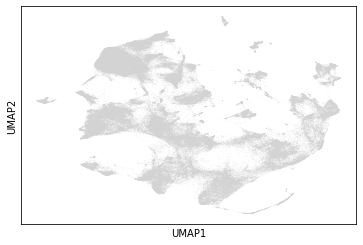

In [14]:
sc.pl.umap(merged_adata)

### Plot similarity by organ

In [197]:
df = merged_adata.obs[["annotation_reference", "organ", "age", "mnn_sim_ratio", "annotation_query", "organ code"]]

KeyError: "['organ', 'age'] not in index"

In [101]:
exclude_labels = anno_groups_dict["OTHER"]

In [21]:
%%R -i df
head(df)

                                          annotation_reference organ age
FCAImmP7579224-ATTACTCTCGATGAGG-reference                  DC3    SK  12
FCAImmP7579224-TGCTACCTCATGTAGC-reference                  DC3    SK  12
FCAImmP7579224-ACGGCCACAAGCTGAG-reference                  DC2    SK  12
FCAImmP7579224-ATTATCCAGGTTACCT-reference                  DC3    SK  12
FCAImmP7579224-GGAGCAACAATGGACG-reference                  DC1    SK  12
FCAImmP7579224-ATCACGATCACGATGT-reference                  DC3    SK  12
                                          mnn_sim_ratio annotation_query
FCAImmP7579224-ATTACTCTCGATGAGG-reference     0.0000000              nan
FCAImmP7579224-TGCTACCTCATGTAGC-reference     0.0000000              nan
FCAImmP7579224-ACGGCCACAAGCTGAG-reference     0.5987848              nan
FCAImmP7579224-ATTATCCAGGTTACCT-reference     0.0000000              nan
FCAImmP7579224-GGAGCAACAATGGACG-reference     0.0000000              nan
FCAImmP7579224-ATCACGATCACGATGT-reference     0.000

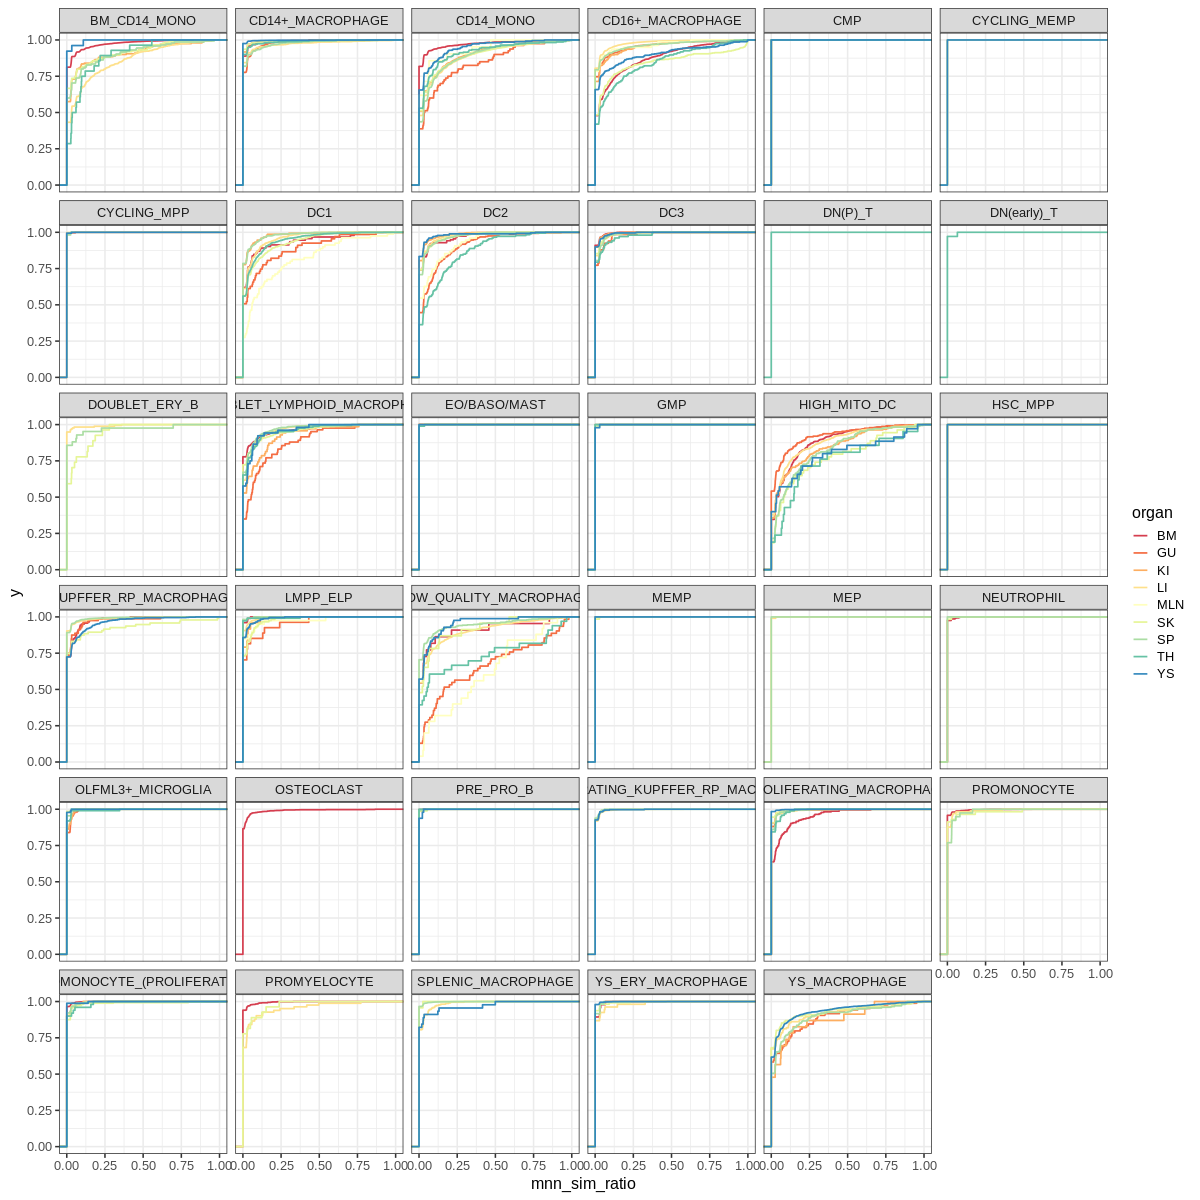

In [115]:
%%R -w 1200 -h 1200
df %>%
    filter(!is.na(organ)) %>%
    group_by(annotation_reference, organ) %>%
    filter(n() > 20) %>%
    ggplot(aes(mnn_sim_ratio, color=organ)) +
    stat_ecdf(size=0.8) +
    theme_bw(base_size=16) +
    facet_wrap(annotation_reference~.) +
    scale_color_brewer(palette = "Spectral")

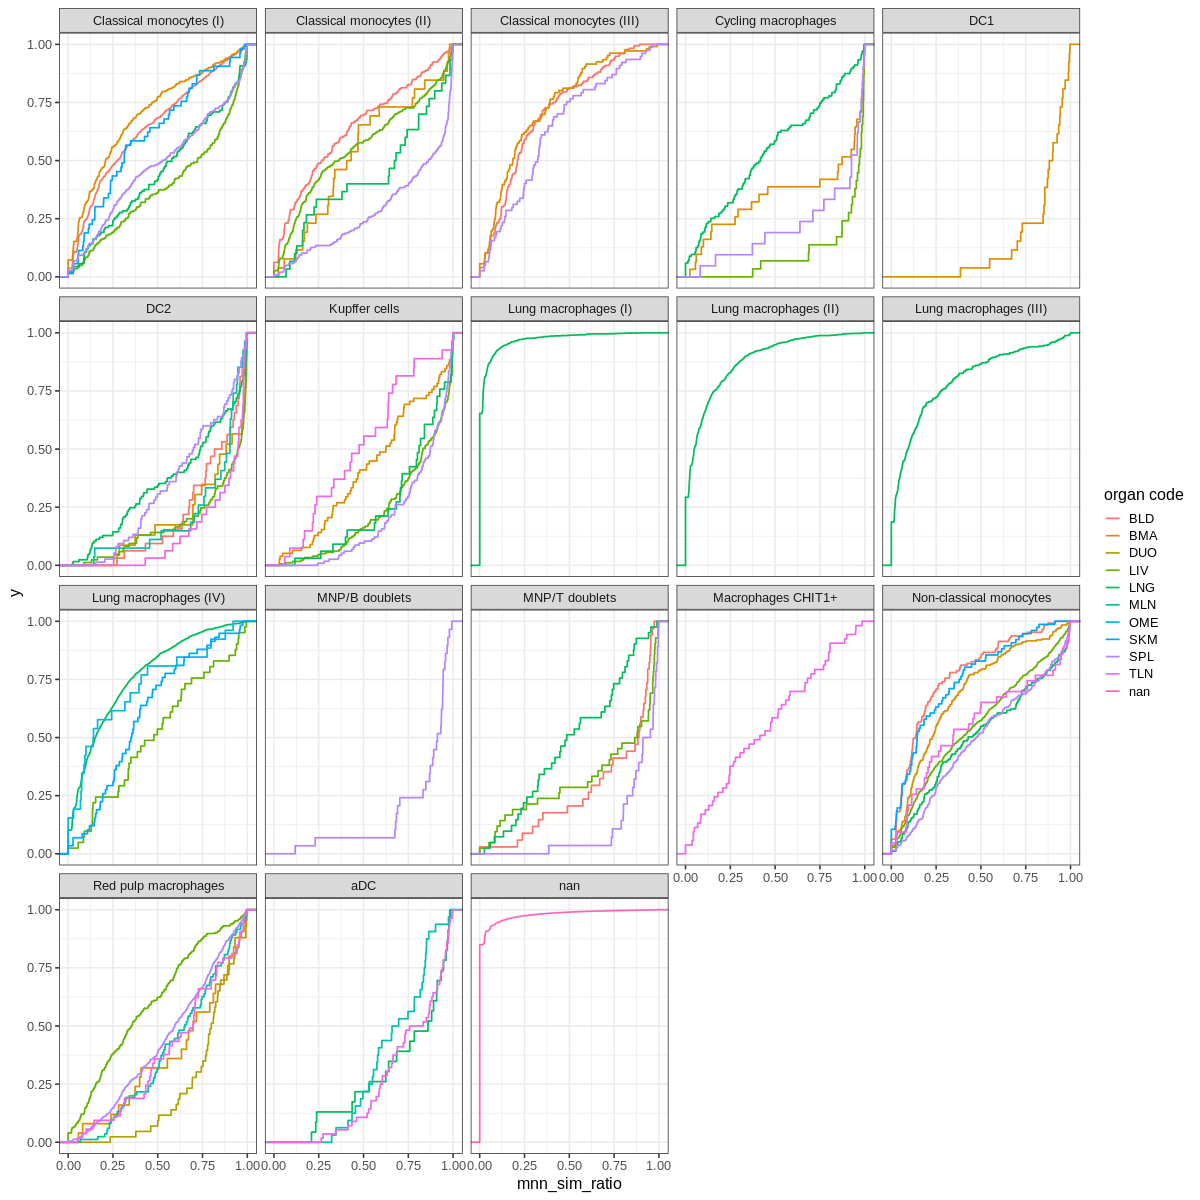

In [116]:
%%R -w 1200 -h 1200
df %>%
    filter(!is.na(`organ code`)) %>%
    group_by(annotation_query, `organ code`) %>%
    filter(n() > 20) %>%
    ggplot(aes(mnn_sim_ratio, color=`organ code`)) +
    stat_ecdf(size=0.8) +
    theme_bw(base_size=16) +
    facet_wrap(annotation_query~.) 


In [50]:
%%R -w 1200 -h 800 -i figdir
df %>%
    filter(annotation_query!="nan") %>%
    filter(!is.na(`organ code`)) %>%
    group_by(annotation_query, `organ code`) %>%
    filter(n() > 20) %>%
    ggplot(aes(`organ code`,mnn_sim_ratio, fill=`organ code`)) +
    geom_violin(scale="width") +
    geom_point(data = . %>% group_by(annotation_query, `organ code`) %>% summarise(median=median(mnn_sim_ratio)), aes(y=median)) +
    theme_bw(base_size=16) +
    facet_wrap(annotation_query~.) +
    scale_fill_brewer(palette="Spectral") +
    ylab("Similarity score") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ggsave(paste0(figdir, "mnn_sim_ratio_by_organ_query.pdf"), height=10, width=15)
    ggsave(paste0(figdir, "mnn_sim_ratio_by_organ_query.png"), height=10, width=15)
    
#     scale_fill_viridis_c(option="magma")

`summarise()` has grouped output by 'annotation_query'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'annotation_query'. You can override using the `.groups` argument.


In [58]:
%%R -w 1200 -h 800 -i figdir
df %>%
#     filter(annotation_query=="nan") %>%
    filter(!is.na(organ)) %>%
    group_by(annotation_reference, organ) %>%
    filter(n() > 20) %>%
    ggplot(aes(organ,mnn_sim_ratio, fill=organ)) +
    geom_violin(scale="width") +
    geom_point(data = . %>% group_by(annotation_reference, organ) %>% summarise(median=median(mnn_sim_ratio)), aes(y=median)) +
    theme_bw(base_size=16) +
    facet_wrap(annotation_reference~.) +
    scale_fill_brewer(palette="Spectral") +
    ylab("Similarity score") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ggsave(paste0(figdir, "mnn_sim_ratio_by_organ_reference.pdf"), height=10, width=15)
    ggsave(paste0(figdir, "mnn_sim_ratio_by_organ_reference.png"), height=10, width=15)
    
#     scale_fill_viridis_c(option="magma")

`summarise()` has grouped output by 'annotation_reference'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'annotation_reference'. You can override using the `.groups` argument.


In [58]:
%%R -w 1200 -h 800 -i figdir
df %>%
#     filter(annotation_query=="nan") %>%
    filter(!is.na(organ)) %>%
    group_by(annotation_reference, organ) %>%
    filter(n() > 20) %>%
    ggplot(aes(organ,mnn_sim_ratio, fill=organ)) +
    geom_violin(scale="width") +
    geom_point(data = . %>% group_by(annotation_reference, organ) %>% summarise(median=median(mnn_sim_ratio)), aes(y=median)) +
    theme_bw(base_size=16) +
    facet_wrap(annotation_reference~.) +
    scale_fill_brewer(palette="Spectral") +
    ylab("Similarity score") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ggsave(paste0(figdir, "mnn_sim_ratio_by_organ_reference.pdf"), height=10, width=15)
    ggsave(paste0(figdir, "mnn_sim_ratio_by_organ_reference.png"), height=10, width=15)
    
#     scale_fill_viridis_c(option="magma")

`summarise()` has grouped output by 'annotation_reference'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'annotation_reference'. You can override using the `.groups` argument.


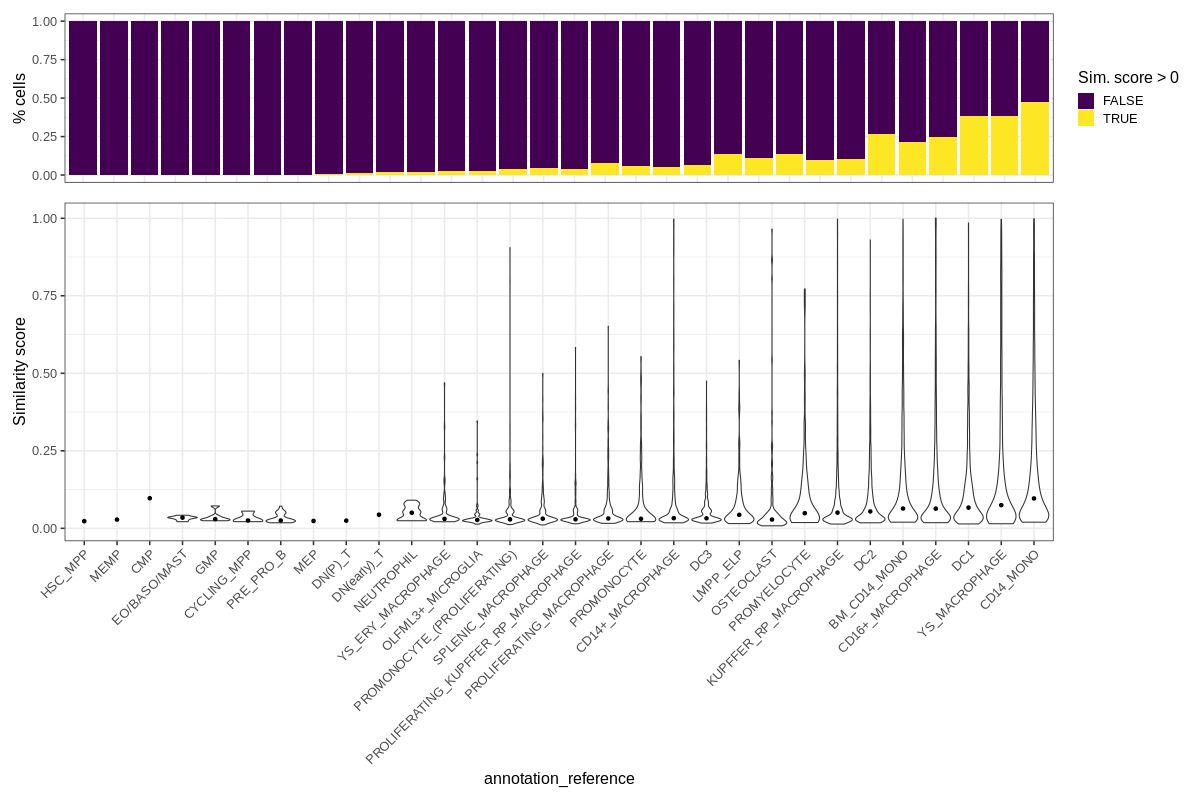

In [103]:
%%R -w 1200 -h 800 -i exclude_labels
top_bp <- df %>%
    filter(!is.na(organ)) %>%
    filter(!annotation_reference %in% exclude_labels) %>%
    group_by(annotation_reference) %>% 
    mutate(median=mean(mnn_sim_ratio)) %>%
    ungroup() %>%
    arrange(median) %>%
    mutate(annotation_reference=factor(annotation_reference, levels=unique(annotation_reference))) %>%
    mutate(sim_cuts = mnn_sim_ratio!=0) %>%
    ggplot(aes(annotation_reference, fill=sim_cuts)) +
    geom_bar(position="fill") +
    scale_fill_viridis_d(name="Sim. score > 0") +
#     geom_violin(scale="width") +
#     geom_point(data = . %>% group_by(annotation_reference) %>% summarise(median=median(mnn_sim_ratio)), aes(y=median)) +
    theme_bw(base_size=16) +
#     facet_wrap(annotation_reference~.) +
#     scale_fill_brewer(palette="Spectral") +
    ylab("% cells") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1))

bottom_vp <- df %>%
    filter(!is.na(organ)) %>%
    filter(!annotation_reference %in% exclude_labels) %>%
    group_by(annotation_reference) %>% 
    mutate(median=mean(mnn_sim_ratio)) %>%
    ungroup() %>%
    arrange(median) %>%
    mutate(annotation_reference=factor(annotation_reference, levels=unique(annotation_reference))) %>%
    filter(mnn_sim_ratio > 0) %>%
    ggplot(aes(annotation_reference, mnn_sim_ratio)) +
    geom_violin(scale="width") +
#     geom_jitter(size=0.1) +
    geom_point(data = . %>% group_by(annotation_reference) %>% summarise(median=median(mnn_sim_ratio)), aes(y=median)) +
    theme_bw(base_size=16) +
#     facet_wrap(annotation_reference~.) +
#     scale_fill_brewer(palette="Spectral") +
    ylab("Similarity score") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1))
    
((top_bp + remove_x_axis()) / bottom_vp) +
plot_layout(heights=c(1,2))

### Plot similarity scores on top of just fetal embedding

In [15]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="MYELOID"

In [16]:
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split))
adata.var_names_make_unique()

In [17]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes["x"] = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])

adata = adata[~adata.obs_names.isin(mat_barcodes["x"])]

In [18]:
### Load annotations

anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
adata = adata[adata.obs_names.isin(anno_obs.index)].copy()
adata.obs["anno_lvl_2_final_clean"] = anno_obs.loc[adata.obs_names]["anno_lvl_2_final_clean"]

In [19]:
adata.obs_names = adata.obs_names + "-reference"

In [20]:
adata.obs["mnn_sim_ratio"] = merged_adata[adata.obs_names].obs["mnn_sim_ratio"]

... storing 'anno_lvl_2_final_clean' as categorical


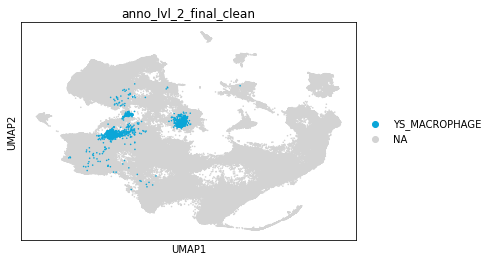

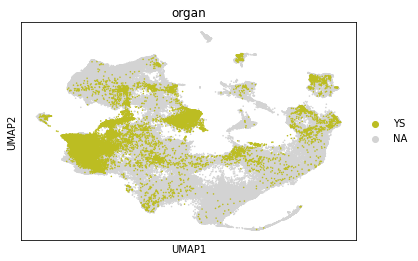

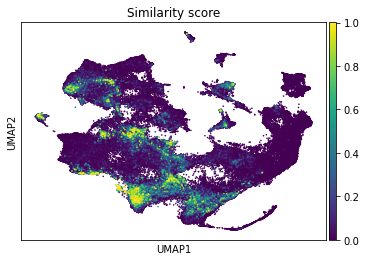

In [21]:
sc.pl.umap(adata, color="anno_lvl_2_final_clean", size=10, groups=["YS_MACROPHAGE"])
sc.pl.umap(adata, color="organ", size=10, groups=["YS"])
sc.pl.umap(adata, color="mnn_sim_ratio", size=10, title="Similarity score", save="similarity_score_justRef.png")

In [138]:
merged_adata.var_names = merged_adata.var['gene_names'].astype('str').copy()
merged_adata.var_names_make_unique()

In [140]:
sc.pp.normalize_total(merged_adata, target_sum=10e4)

In [141]:
sc.pp.log1p(merged_adata)

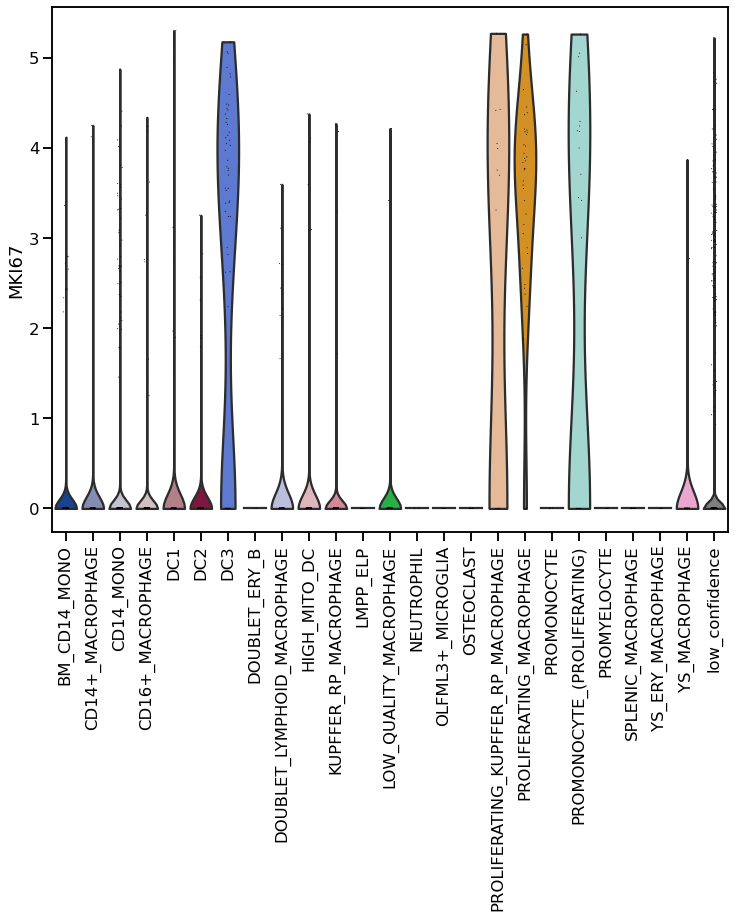

In [142]:
sc.pl.violin(merged_adata, "MKI67", groupby="predicted_anno", rotation=90)

### Visualize predicted identities for most similar cells

In [37]:
merged_adata.obs["dataset"] = ["reference" if x == "query" else 'query' for x in merged_adata.obs["dataset"]]
del merged_adata.obs["predicted_anno"]

In [206]:
anno_col="annotation_query"
neighbors_key="connectivities"
min_score=0
# min_ref_neighbors = adata.uns["neighbors"]["params"]["n_neighbors"]/10
min_ref_neighbors = 1
missing_anno = merged_adata.obs["dataset"] == "query"
w_anno = merged_adata.obs["dataset"] == "reference"

## Find neighbors of cells with conflicting annotation
knn_graph = merged_adata.obsp[neighbors_key]
knn_graph_query = knn_graph[missing_anno,:][:,w_anno]
knn_graph_query[knn_graph_query.nonzero()] = 1

In [207]:
## Find most abundant cell label in neighbors
neighbors_labels = pd.DataFrame()
n_neighbors_labels = pd.DataFrame()

annos = merged_adata.obs.loc[w_anno,anno_col].copy()

dummy_df = pd.get_dummies(annos)
dummy_mat = scipy.sparse.csr_matrix(dummy_df)

new_anno = knn_graph_query.dot(dummy_mat).toarray()

n_neighbors = np.array(knn_graph_query.sum(1)).flatten()
n_neighbors_ref = new_anno.sum(axis=1)
new_anno_prob = new_anno.T/n_neighbors_ref
new_anno_prob[np.isnan(new_anno_prob)] = 0
new_anno_prob[:,n_neighbors_ref < min_ref_neighbors] = 0

best_label = dummy_df.columns[new_anno_prob.argmax(0)].values
best_label_score = new_anno_prob.max(0)

best_label[best_label_score <= min_score] = "low_confidence"

merged_adata.obs.loc[missing_anno,'predicted_anno'] = best_label
merged_adata.obs.loc[missing_anno,'predicted_anno_prob'] = best_label_score

best_label = dummy_df.columns[new_anno_prob.argmax(0)].values
best_label_score = new_anno_prob.max(0)

best_label[best_label_score <= min_score] = "low_confidence"

In [341]:
fetal_sim_df = merged_adata_clean.obs[merged_adata_clean.obs.dataset=="query"][["mnn_sim_ratio", "predicted_anno", "annotation_reference"]]


adult_annos_order = ['Intermediate monocytes','Classical monocytes (I)', 'Classical monocytes (II)',
       'Classical monocytes (III)', 'Non-classical monocytes','Cycling macrophages', 'DC1', 'DC2','aDC',
         'Lung macrophages (I)',
       'Lung macrophages (II)', 'Lung macrophages (III)',
       'Lung macrophages (IV)', 
       'Macrophages CHIT1+',
 'Kupffer cells',
       'Red pulp macrophages', 'MNP/B doublets', 'MNP/T doublets','low_confidence']

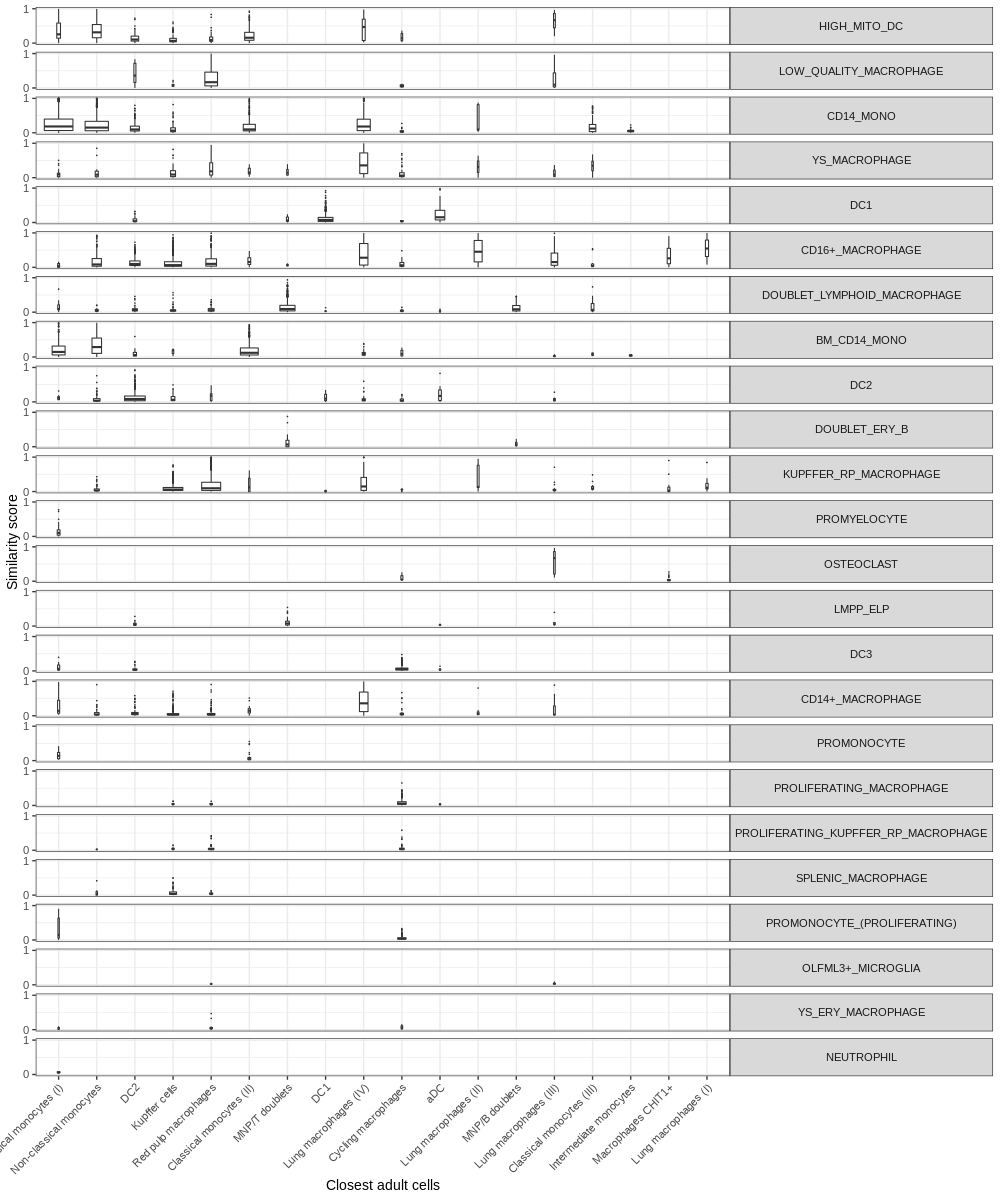

In [232]:
%%R -w 1000 -h 1200
pl_df <-fetal_sim_df %>%
    group_by(annotation_reference) %>%
    mutate(mean_sim=mean(mnn_sim_ratio)) %>%
    ungroup() %>%
    arrange(-mean_sim) %>%
    filter(predicted_anno!="low_confidence") %>%
    mutate(annotation_reference=factor(annotation_reference, levels=unique(annotation_reference))) %>%
    group_by(predicted_anno, annotation_reference) %>%
#     summarise(n=n(), mean_similarity=mean(mnn_sim_ratio), sd_similarity=sd(mnn_sim_ratio)) %>%
    mutate(n=n(), mean_similarity=mean(mnn_sim_ratio)) %>%
    ungroup() %>%
    filter(n > 5) 
    
pl_df %>%
#     group_by(annotation_reference) %>%
    arrange(-n, -mean_similarity) %>%
    mutate(predicted_anno=factor(predicted_anno, levels=unique(predicted_anno))) %>%
#     mutate(max_sim_anno = predicted_anno[max_sim]) %>%
    ggplot(aes(predicted_anno, mnn_sim_ratio)) +
    geom_boxplot(outlier.size=0.05, varwidth=TRUE) +
    scale_y_continuous(breaks=c(0,1)) +
    facet_grid(annotation_reference~.) +
    xlab("Closest adult cells") +
    ylab("Similarity score") +
    theme_bw(base_size=14) +
    theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1),
         strip.text.y = element_text(angle=0))

In [466]:
%%R -h 2000 -w 2000 -i adult_annos_order -i figdir

pl_df <- fetal_sim_df %>%
    group_by(annotation_reference) %>%
    mutate(mean_sim=mean(mnn_sim_ratio)) %>%
    ungroup() %>%
    arrange(-mean_sim) %>%
    filter(predicted_anno!="low_confidence") %>%
    mutate(annotation_reference=factor(annotation_reference, levels=unique(annotation_reference))) %>%
    filter(mnn_sim_ratio > 0) %>%
    filter(predicted_anno!="low_confidence") %>%
    group_by(predicted_anno, annotation_reference) %>%
#     summarise(n=n(), mean_similarity=mean(mnn_sim_ratio), sd_similarity=sd(mnn_sim_ratio)) %>%
    mutate(n=n(), mean_similarity=mean(mnn_sim_ratio)) %>%
    ungroup() %>%
    filter(n > 10) %>%
    mutate(predicted_anno=factor(predicted_anno, levels=adult_annos_order[adult_annos_order %in% predicted_anno])) 



# ----- This section prepare a dataframe for labels ---- #
# Get the name and the y position of each label
label_data <- data.frame(predicted_anno=levels(pl_df[["predicted_anno"]])) %>%
    rowid_to_column()
 
# calculate the ANGLE of the labels
number_of_bar <- length(adult_annos_order)
angle <-  90 - 360 * (label_data$rowid) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)
 
# calculate the alignment of labels: right or left
# If I am on the left part of the plot, my labels have currently an angle < -90
label_data$hjust<-ifelse( angle < -90, 1, 0)
 
# flip angle BY to make them readable
label_data$angle<-ifelse(angle < -90, angle+180, angle)
# ----- ------------------------------------------- ---- #

plot_swatch <- function(anno){
    small_pl_df <- pl_df  %>%
            left_join(label_data) %>%
            mutate(predicted_anno=factor(predicted_anno, levels=adult_annos_order[adult_annos_order %in% predicted_anno])) 
    angles <- small_pl_df %>% filter(annotation_reference==anno)%>% 
        group_by(predicted_anno) %>% 
        summarise(mnn_sim_ratio=1.3, angle=first(angle), hjust=first(hjust))
    small_pl_df %>%
    ggplot(aes(predicted_anno, mnn_sim_ratio)) +
    geom_point(size=0, width=0.5, alpha=0.1, color=NA) +
    ggbeeswarm::geom_quasirandom(data= . %>% filter(annotation_reference==anno), size=0.5, width=0.5, color="red") +
    geom_text(data =  . %>% filter(annotation_reference==anno)%>% group_by(predicted_anno) %>% summarise(mnn_sim_ratio=1.1, angle=first(angle), hjust=first(hjust)), 
               aes( label=predicted_anno,
                   hjust=hjust,
                  ),angle=angles$angle, size=6) +
    theme_classic(base_size=18) +
    geom_hline(yintercept=1) +
    coord_polar() +
    expand_limits(y = c(0,3)) +
    scale_fill_viridis_c() +
    ylab("Similarity score") +
    xlab("") +
#     ggbeeswarm::geom_quasirandom(size=0.05, width=0.5, alpha=0.1) +
    scale_y_continuous(breaks=c(0,1)) +
    theme(axis.text.x = element_blank(),
         strip.text.y = element_text(angle=0),
          
         ) +
    ggtitle(anno)
}

for (a in levels(pl_df$annotation_reference)){
    plot_swatch(a) + ggsave(paste0(figdir, "similarity_swatch_", str_replace_all(a, "/", "_"), ".pdf"), width=12, height=8)
}

Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining, by = "predicted_anno"
Joining,